In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import math
import random
import os
import time

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from utils import read_images, augment_gpu, augment_easy, random_picture, pictures_per_year, graph
from inception_preprocessing import preprocess_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

random.seed(1)

## Bilder lesen, resizing und export numpy

In [2]:
# Konstanten für Input Pipeline
PATH = "C:\\Users\\Toem\\Desktop\\BA\\Datensets\\Bilder-nach-Baujahren"
TEST_TO_TRAIN_RATIO = 0.15
NUM_CLASSES = 1
IMG_HEIGHT = 240
IMG_WIDTH = 240
CHANNELS = 3

1708 Bilder einzulesen dauerte 105.81 Sekunden.
trainX: (1708, 240, 240, 3)
trainY: (1708, 1)


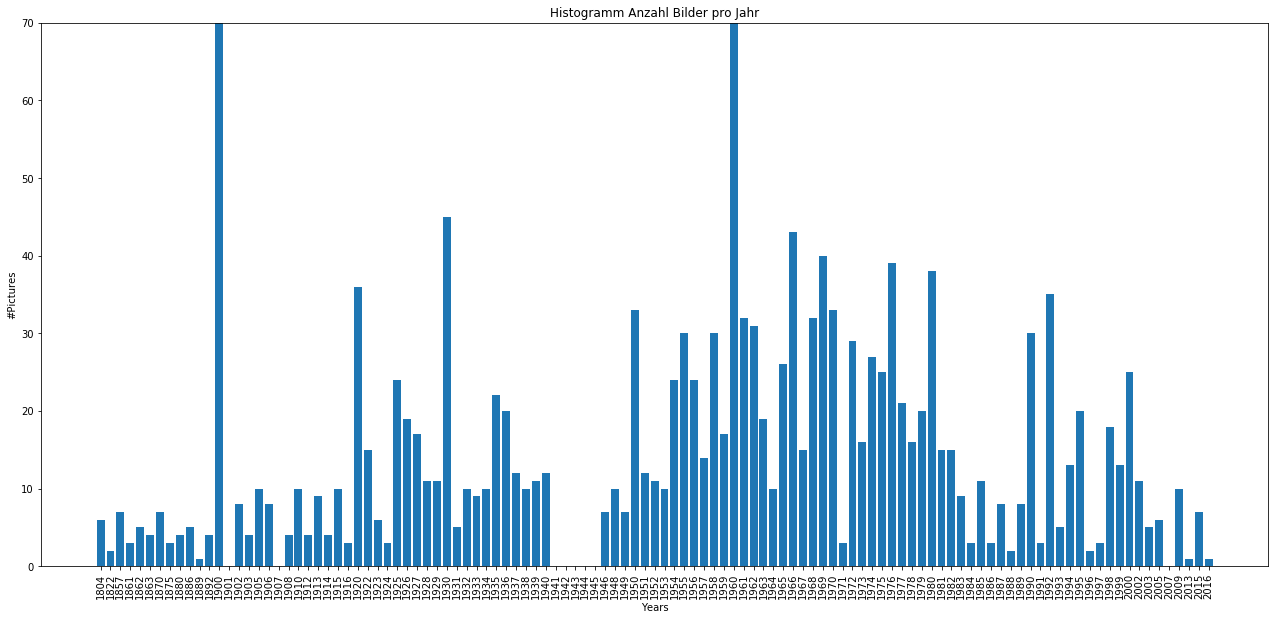

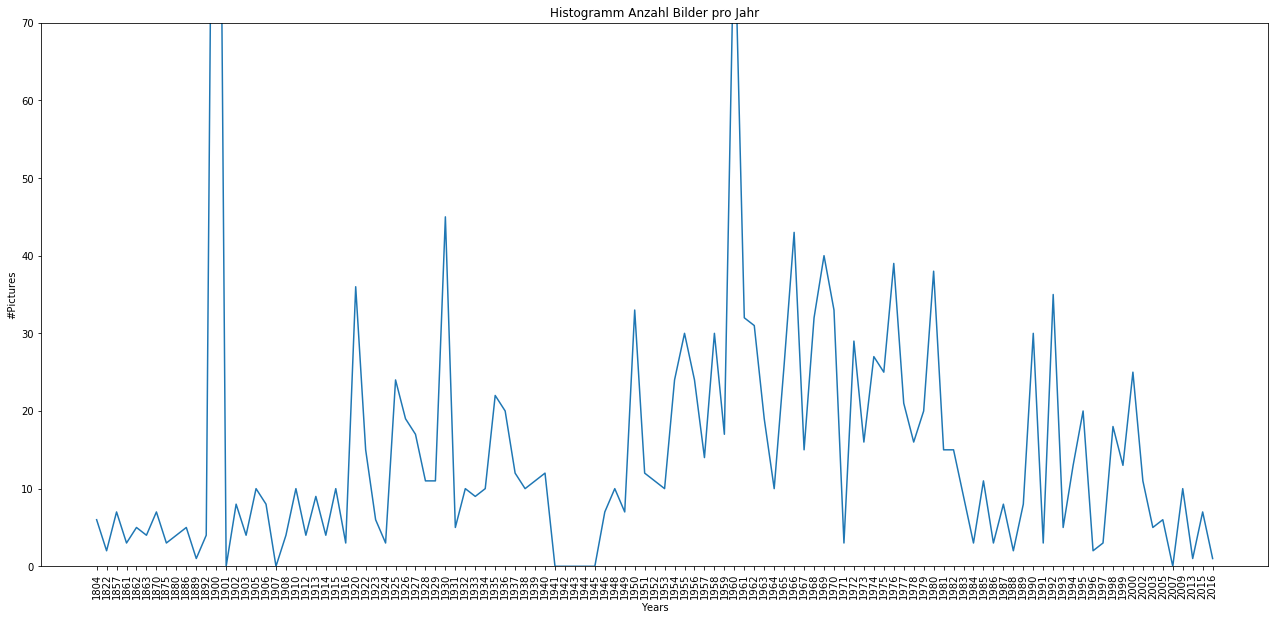

In [3]:
X, Y = read_images(PATH, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

In [4]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=TEST_TO_TRAIN_RATIO)

trainX = trainX / 255
testX = testX / 255

del X
del Y

print("Dimension of trainX: " + str(trainX.shape))
print("Dimension of trainY: " + str(trainY.shape))
print("Dimension of testX: " + str(testX.shape))
print("Dimension of testY: " + str(testY.shape))

Dimension of trainX: (1451, 240, 240, 3)
Dimension of trainY: (1451, 1)
Dimension of testX: (257, 240, 240, 3)
Dimension of testY: (257, 1)


Random picture trainX
Baujahr: [1955], Index: 275


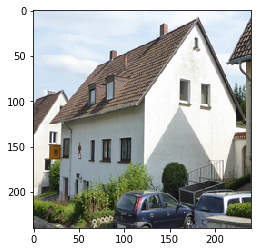

In [5]:
print("Random picture trainX")
random_picture(trainX, trainY)

Random picture testX
Baujahr: [1966], Index: 32


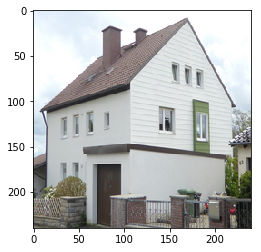

In [6]:
print("Random picture testX")
random_picture(testX, testY)

## TensorFlow Initialisierung Variablen und DataSet

In [7]:
def initialize_variables(c1, c2, c3, fc, patch1=6, patch2=5, patch3=4, bias_init=0.01, std=0.1):
    # TF Hyperparameter
    batch_size = tf.placeholder(tf.int64)
    pkeep = tf.placeholder(tf.float32)

    # TF Inputvariablen für Dataset
    x = tf.placeholder(tf.float32, shape=[None, IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    y = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES])

    # TF Netzwerkparameter (weights und biases)
    W1 = tf.Variable(tf.truncated_normal([patch1, patch1, CHANNELS, c1], stddev=std))
    B1 = tf.Variable(tf.constant(bias_init, tf.float32, [c1]))            
    W2 = tf.Variable(tf.truncated_normal([patch2, patch2, c1, c2], stddev=std))
    B2 = tf.Variable(tf.constant(bias_init, tf.float32, [c2]))
    W3 = tf.Variable(tf.truncated_normal([patch3, patch3, c2, c3], stddev=std))
    B3 = tf.Variable(tf.constant(bias_init, tf.float32, [c3]))

    W4 = tf.Variable(tf.truncated_normal([int(IMG_HEIGHT/4) * int(IMG_HEIGHT/4) * c3, fc], stddev=std))
    B4 = tf.Variable(tf.constant(bias_init, tf.float32, [fc]))

    W5 = tf.Variable(tf.truncated_normal([fc, NUM_CLASSES], stddev=std))
    B5 = tf.Variable(tf.constant(bias_init, tf.float32, [NUM_CLASSES]))

    # TF sonstige Parameter
    i = tf.placeholder(tf.int32)
    testing = tf.placeholder(tf.bool)
    
    parameters = {"W1": W1, "B1": B1, "W2": W2, "B2": B2, "W3": W3, "B3": B3, "W4": W4, "B4": B4, "W5": W5, "B5": B5}
    
    return x, y, i, testing, batch_size, pkeep, parameters
    

def initialize_datasets(x, y, examples_train, examples_test, epochs, batch_size, augmentation=None):
    dataset_train = tf.data.Dataset.from_tensor_slices((x, y))
    dataset_train = dataset_train.apply(tf.contrib.data.shuffle_and_repeat(buffer_size=examples_train, count=epochs+1))
    dataset_train = dataset_train.batch(batch_size)
    
    if augmentation != None:
        dataset_train = dataset_train.map(input_parser(augmentation, num_parallel_calls=4))

    dataset_test = tf.data.Dataset.from_tensor_slices((x, y))
    dataset_test = dataset_test.apply(tf.contrib.data.shuffle_and_repeat(buffer_size=examples_test, count=epochs))
    dataset_test = dataset_test.batch(batch_size)

    # Iterator 
    iterator_train = dataset_train.make_initializable_iterator()
    iterator_test = dataset_test.make_initializable_iterator()

    
    return iterator_train, iterator_test   
    

## Data augmentation

In [8]:
# Data augmentation, 4-D Tensor input
def input_parser(images, labels, augment="augment_easy"):
    
    if method == "augment_gpu":
        augmented_images, labels = augment_gpu(images, labels, horizontal_flip=False, vertical_flip=True, rotate=0, crop_probability=0.3)
    
    if method == "augment_easy":
        augmented_images, labels = augment_easy(images, labels)
    
    if method == "augment_inception":
        augmented_images = tf.map_fn(lambda img: preprocess_image(img, height=IMG_HEIGHT, width=IMG_WIDTH, is_training=True), images)
    
    
    return augmented_images, labels

In [9]:
def get_input_batch_data(testing, iterator_train, iterator_test):
    features, labels = tf.cond(testing, lambda: iterator_test.get_next(), lambda: iterator_train.get_next())
    return features, labels

## Batchnorm

In [10]:
def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_averages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_averages

def no_batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    return Ylogits, tf.no_op()

## Netzwerkarchitektur

In [11]:
def forward_pass(features, labels, parameters, pkeep, i, testing):
    # CONV Layer 1
    stride = 1
    A1l = tf.nn.conv2d(features, parameters["W1"], strides=[1, stride, stride, 1], padding="SAME")
    A1bn, update_ema1 = no_batchnorm(A1l, testing, i, parameters["B1"], convolutional=True)
    A1 = tf.nn.relu(A1bn)

    # Conv Layer 2
    stride = 2
    A2l = tf.nn.conv2d(A1, parameters["W2"], strides=[1, stride, stride, 1], padding="SAME")
    A2bn, update_ema2 = no_batchnorm(A2l, testing, i, parameters["B2"], convolutional=True)
    A2 = tf.nn.relu(A2bn)

    # Conv Layer 3
    stride = 2
    A3l = tf.nn.conv2d(A2, parameters["W3"], strides=[1, stride, stride, 1], padding="SAME")
    A3bn, update_ema3 = no_batchnorm(A3l, testing, i, parameters["B3"], convolutional=True)
    A3 = tf.nn.relu(A3bn)

    # Flatten Layer 3
    # A3 = tf.reshape(A3, shape=[-1, int(IMG_HEIGHT/4) * int(IMG_HEIGHT/4) * CONV_LAYER3])
    A3 = tf.contrib.layers.flatten(A3)

    # FC Layer 4
    A4l = tf.matmul(A3, parameters["W4"]) + parameters["B4"]
    A4bn, update_ema4 = no_batchnorm(A4l, testing, i, parameters["B4"])
    A4 = tf.nn.relu(A4bn)

    # Dropout Layer 5
    A4 = tf.nn.dropout(A4, pkeep) 

    # FC Layer 6
    Ypreds = tf.matmul(A4, parameters["W5"]) + parameters["B5"]
    
    return Ypreds

## Modell

In [12]:
def model(layer1=12, layer2=24, layer3=48, fclayer=200, epochs=100, batchsize=16, bn=False, pkeep=0.5, 
          init_lr=0.02, decayed_lr=0.0001, decay_steps=1600, augmentation=None):
    
    NUM_EXAMPLES_TRAIN = len(trainX)
    NUM_EXAMPLES_TEST = len(testX)
    NUM_BATCHES = NUM_EXAMPLES_TRAIN // batchsize
    
    print("NUM_EXAMPLES_TRAIN: " + str(NUM_EXAMPLES_TRAIN))
    print("NUM_EXAMPLES_TEST: " + str(NUM_EXAMPLES_TEST))
    print("NUM_BATCHES: " + str(NUM_BATCHES))
    
    epoch_losses_train = list()
    epoch_losses_test = list()
    epoch_elapsed_times = list()
    
    # 1) initialize variables
    x, y, i, testing, batch_size, pkeep, parameters = initialize_variables(
        layer1, layer2, layer3, fclayer, patch1=6, patch2=5, patch3=4, bias_init=0.01, std=0.1)
    
    # 2) init datasets
    iterator_train, iterator_test = initialize_datasets(x, y, NUM_EXAMPLES_TRAIN, NUM_EXAMPLES_TEST, epochs, batchsize, augmentation)
    
    # 3) input batch for forward pass
    features, labels = get_input_batch_data(testing, iterator_train, iterator_test)
    
    # 4) forward pass
    Ypreds = forward_pass(features, labels, parameters, pkeep, i, testing)
    
    # 5) loss
    # loss = tf.losses.mean_squared_error(predictions=Ypreds, labels=labels, reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)
    # update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)
    loss = tf.reduce_mean(tf.squared_difference(Ypreds, labels))
    
    # 6) train step
    lr = init_lr + tf.train.exponential_decay(decayed_lr, i, decay_steps, 1/math.e)
    train_step = tf.train.AdamOptimizer(lr).minimize(loss)
    
    # 7) Loop over epochs, batches
    with tf.Session() as sess:
        # init global variables
        sess.run(tf.global_variables_initializer())
        
        # initialise with train data
        sess.run(iterator_train.initializer, feed_dict={x: trainX, y: trainY, batch_size: batchsize})
        
        # initialise with test data
        sess.run(iterator_test.initializer, feed_dict={x: testX, y: testY, batch_size: NUM_EXAMPLES_TEST})

  
        for j in range(epochs):
        
            tic = time.time()
            epoch_train_losses = []
            
            for k in range(NUM_BATCHES):
                iters_total = j*NUM_BATCHES + k

                # training
                _, batch_loss = sess.run([train_step, loss], feed_dict={testing: False, i: iters_total, pkeep: 0.5})
                epoch_train_losses.append(batch_loss)

            # test loss nach 1 epoch
            epoch_test_loss = sess.run(loss, feed_dict={testing: True, i: iters_total, pkeep: 1})
            epoch_losses_test.append(epoch_test_loss)
            
            # train loss after 1 batch
            epoch_train_loss = np.mean(epoch_train_losses)
            epoch_losses_train.append(epoch_train_loss)

            # train loss nach 1 epoch
            # epoch_train_loss /= NUM_BATCHES
            # epoch_losses_train.append(epoch_train_loss)
            #epoch_train_loss = np.mean(epoch_train_losses)
            #epoch_losses_train.append(epoch_train_loss)
            
            toc = time.time()
            epoch_elapsed = toc-tic
            epoch_elapsed_times.append(epoch_elapsed)
            
            # logging
            print("Iter: %d, Epoch: %d (%.2fs), Train-Loss: %d, Test-Loss: %d" % (iters_total, 
                                                                                  j, epoch_elapsed, 
                                                                                  epoch_train_loss, 
                                                                                  epoch_test_loss))
            
  
        print("Dauer insgesamt: %.2f, Average Time per Epoch: %.2f" % (sum(epoch_elapsed_times), 
                                                                       (sum(epoch_elapsed_times) / float(len(epoch_elapsed_times)))))
        graph(epoch_losses_train, epoch_losses_test)
    
    
    

## Auswertung

Iter: 89, Epoch: 0 (12.70s), Train-Loss: 24628900, Test-Loss: 83739
Iter: 179, Epoch: 1 (4.92s), Train-Loss: 188677, Test-Loss: 74483
Iter: 269, Epoch: 2 (4.87s), Train-Loss: 225474, Test-Loss: 64800
Iter: 359, Epoch: 3 (5.21s), Train-Loss: 203792, Test-Loss: 48285
Iter: 449, Epoch: 4 (4.82s), Train-Loss: 232336, Test-Loss: 38763
Iter: 539, Epoch: 5 (4.86s), Train-Loss: 271876, Test-Loss: 55173
Iter: 629, Epoch: 6 (4.91s), Train-Loss: 228964, Test-Loss: 288936
Iter: 719, Epoch: 7 (4.78s), Train-Loss: 205644, Test-Loss: 45702
Iter: 809, Epoch: 8 (4.77s), Train-Loss: 228609, Test-Loss: 85823
Iter: 899, Epoch: 9 (4.76s), Train-Loss: 241353, Test-Loss: 106914
Iter: 989, Epoch: 10 (4.76s), Train-Loss: 198433, Test-Loss: 83515
Iter: 1079, Epoch: 11 (4.74s), Train-Loss: 247305, Test-Loss: 70304
Iter: 1169, Epoch: 12 (4.76s), Train-Loss: 196082, Test-Loss: 96893
Iter: 1259, Epoch: 13 (4.78s), Train-Loss: 169358, Test-Loss: 54245
Iter: 1349, Epoch: 14 (4.84s), Train-Loss: 166453, Test-Loss: 714

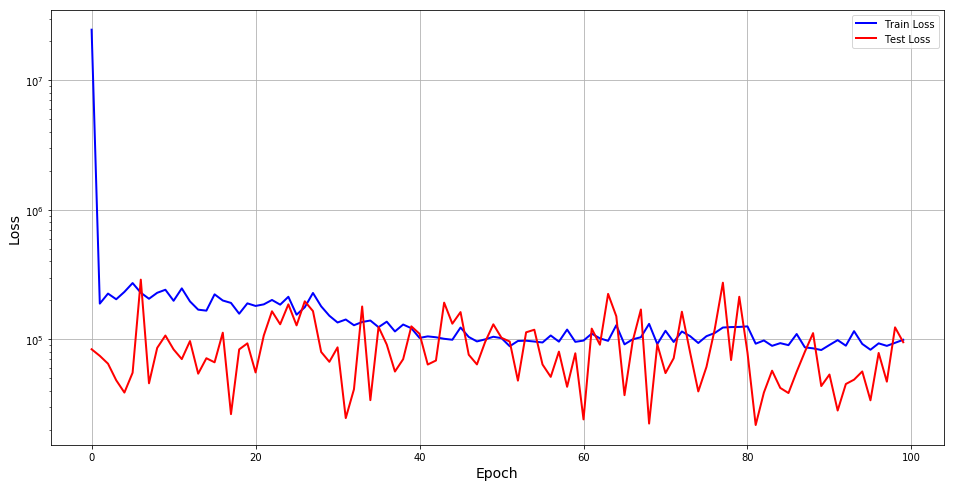

In [15]:
# erstes tests mit neuer model fn
# train losses, test losses noch falsch

model(layer1=12, layer2=24, layer3=48, fclayer=200, epochs=100, batchsize=16, bn=False, pkeep=0.5, 
          init_lr=0.02, decayed_lr=0.0001, decay_steps=1600, augmentation=None)

NUM_EXAMPLES_TRAIN: 1451
NUM_EXAMPLES_TEST: 257
NUM_BATCHES: 90
Instructions for updating:
Use the retry module or similar alternatives.
Iter: 89, Epoch: 0 (18.42s), Train-Loss: 126063776, Test-Loss: 3784502
Iter: 179, Epoch: 1 (5.01s), Train-Loss: 3575396, Test-Loss: 3240483
Iter: 269, Epoch: 2 (4.82s), Train-Loss: 3045392, Test-Loss: 2592813
Iter: 359, Epoch: 3 (4.78s), Train-Loss: 2189273, Test-Loss: 1695081
Iter: 449, Epoch: 4 (4.78s), Train-Loss: 1221429, Test-Loss: 708943
Iter: 539, Epoch: 5 (4.78s), Train-Loss: 455489, Test-Loss: 183544
Iter: 629, Epoch: 6 (4.80s), Train-Loss: 190855, Test-Loss: 29589
Iter: 719, Epoch: 7 (4.80s), Train-Loss: 135731, Test-Loss: 11239
Iter: 809, Epoch: 8 (4.80s), Train-Loss: 130917, Test-Loss: 3882
Iter: 899, Epoch: 9 (4.79s), Train-Loss: 120879, Test-Loss: 4900
Iter: 989, Epoch: 10 (4.79s), Train-Loss: 130533, Test-Loss: 4101
Iter: 1079, Epoch: 11 (4.80s), Train-Loss: 120796, Test-Loss: 4001
Iter: 1169, Epoch: 12 (4.77s), Train-Loss: 115940, Test

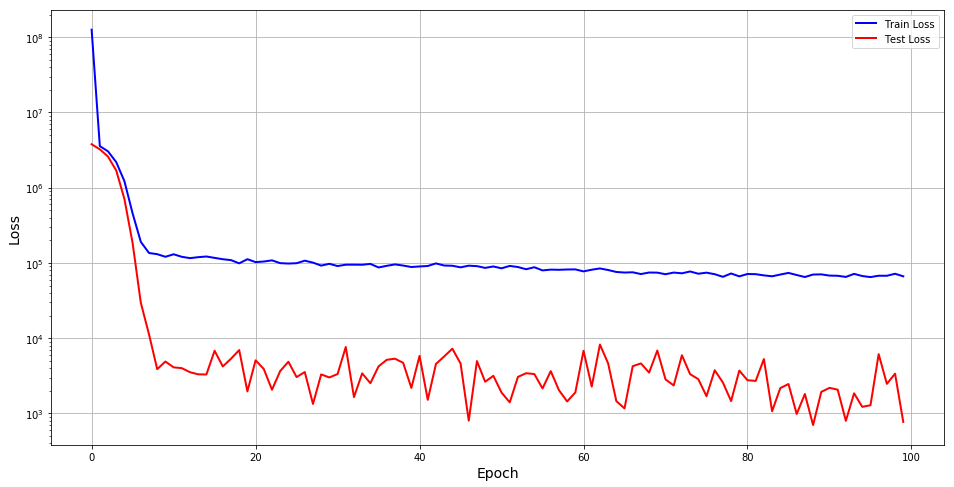

In [13]:
# erstes tests mit neuer model fn
# stackoverflow 

model(layer1=12, layer2=24, layer3=48, fclayer=200, epochs=100, batchsize=16, bn=False, pkeep=0.5, 
          init_lr=0.02, decayed_lr=0.0001, decay_steps=1600, augmentation=None)